<a href="https://colab.research.google.com/github/Sankarsh-Sunku/Implementation-Of-DL-in-Pytorch/blob/main/FFN_Project/For_Missing_Data_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

# for number-crunching
import numpy as np

import copy

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns

<ipython-input-1-e4386f73a832>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
# import the data
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# z-score all columns
data = (data - data.mean())/data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

In [3]:
dataOrig

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217415,0.403103,-0.980362,-0.382151,0.053829,1.541571,-0.075020,-0.978459,0.899605,-0.461036,0.072271,-0.787576
1595,-1.389721,0.123866,-0.877693,-0.240300,-0.541090,2.210777,0.137777,-0.861893,1.353012,0.600867,0.729136,0.450707
1596,-1.159980,-0.099523,-0.723690,-0.169374,-0.243630,1.254769,-0.196617,-0.533387,0.705287,0.541872,0.541460,0.450707
1597,-1.389721,0.654416,-0.775024,-0.382151,-0.264878,1.541571,-0.075020,-0.676446,1.676875,0.305894,-0.209243,-0.787576


In [4]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
# (note: in the video I don't have replace=False, which means it's possible to select the same values twice)
whichVals2nan = np.random.choice(range(len(data)),size=n2nan,replace=False)

# set those values to be nan (safe to ignore the overwrite warning)
data['residual sugar'][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data['residual sugar'].isna())[0]

# confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 203  249  365  474  485  505  887  962 1075 1394]
[ 203  249  365  474  485  505  887  962 1075 1394]


<ipython-input-4-2741c3db02a0>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['residual sugar'][whichVals2nan] = np.nan


In [5]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('residual sugar')

# extract dataframe to TRAIN tensors
train_dataT  = torch.tensor( data[cols2keep].values ).float()
train_dataT  = train_dataT[whichValsNotNan,:]
train_labelT = torch.tensor( data['residual sugar'].values ).float()
train_labelT = train_labelT[whichValsNotNan,None] # the 'None' is transform to matrix


# same for TEST tensors
test_dataT  = torch.tensor( dataOrig[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2nan,:]
test_labelT = torch.tensor( dataOrig['residual sugar'].values ).float()
test_labelT = test_labelT[whichVals2nan,None] # the 'None' is transform to matrix

# confirm sizes
print(f'Original data: {data.shape}\n')
print(f'   Train data: {train_dataT.shape}\n')
print(f' Train labels: {train_labelT.shape}\n')
print(f'    Test data: {test_dataT.shape}\n')
print(f'  Test labels: {test_labelT.shape}')

Original data: (1599, 12)

   Train data: torch.Size([1589, 11])

 Train labels: torch.Size([1589, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [6]:
# then convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT,train_labelT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [7]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [8]:
# a function that trains the model

# global parameter
numepochs = 400

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_data:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

  # function output
  return trainLoss

In [9]:
# create a model and train it
winenet = ANNwine()
trainLoss = trainTheModel()

In [10]:
# get the predictions for the missing data
yHatTrain = winenet(train_dataT)
yHatTest  = winenet(test_dataT)

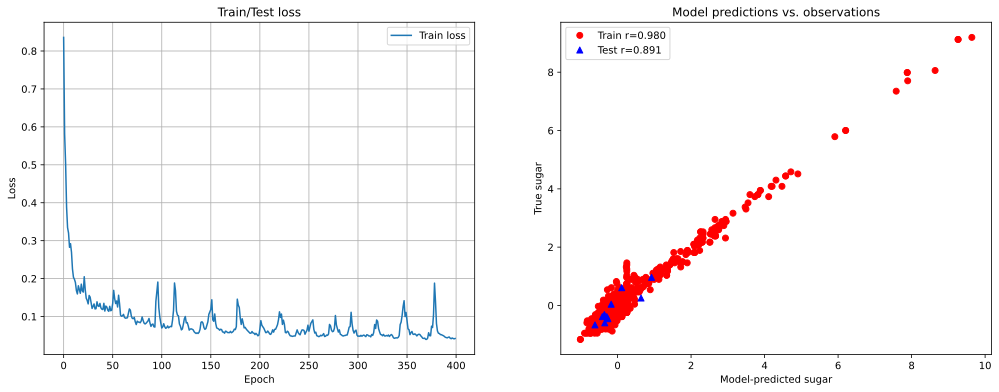

In [11]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()